<div class="alert alert-info">
<u><strong>Authors:</strong></u> <b>Alberto Vavassori</b> (alberto.vavassori@polimi.it), <b>Emanuele Capizzi</b> (emanuele.capizzi@polimi.it) - DICA - Politecnico di Milano - GIS GEOLab <br>
Developed within the LCZ-ODC project, funded by the Italian Space Agency (agreement n. 2022-30-HH.0).
</div>

# Plotting - data exploration and visualization

<a id='TOC_TOP'></a>
Notebook structure:  <br>
 1. [Spectral signature plotting](#sec1)  
 2. [Band correlation](#sec2)
<hr>

This Notebook contains recipes to explore and visualize PRISMA and Sentinel-2 data (e.g. spectral signatures, statistics, band correlation etc.).

The first part of the Notebook is dedicated to the visualization of the spectral signatures for the LCZs. The user can visualize the signature of single pixels as well as of the training samples through static and interactive plots. Signatures are computed from both Sentinel-2 and PRISMA data which allows the user to easily compare the information provided by the two satellite sensors.

The second part of the Notebook is dedicated to the visualization of PRISMA band correlation.

Here is a thematic representation of the PRISMA and Sentinel-2 spectral bands and spatial resolutions:

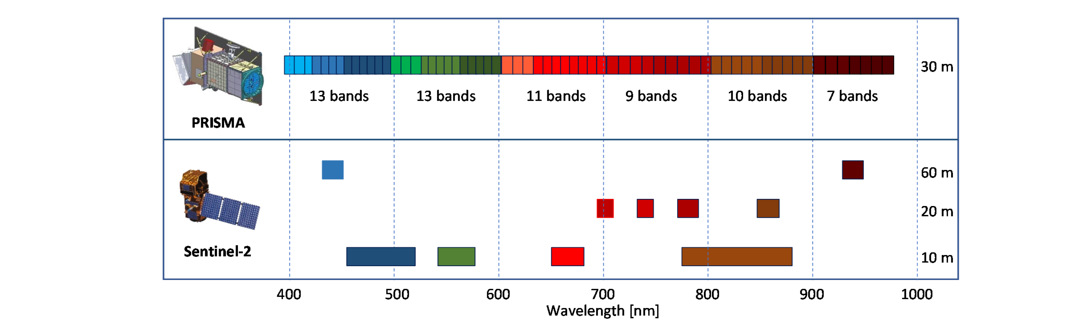

Image taken from [Niroumand-Jadidi, M.; Bovolo, F.; Bruzzone, L. Water Quality Retrieval from PRISMA Hyperspectral Images: First Experience in a Turbid Lake and Comparison with Sentinel-2. *Remote Sens.* **2020**, 12, 3984](https://doi.org/10.3390/rs12233984).

## Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import rasterio as rio
from rasterio import mask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import ipywidgets as widgets
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import geopandas as gpd
from scipy.stats import linregress
import xml.dom.minidom


import IPython.display as display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.ticker as ticker
from plotly import graph_objs as go

In [ ]:
# Import functions and set auto-reload
from functions import *
%load_ext autoreload
%autoreload 2

# 1. Spectral signature plotting <a id='sec1'> </a>

[Back to top](#TOC_TOP)

## Pixel spectral signature

Open the PRISMA and Sentinel-2 files to retrieve the band central wavelengths:

In [ ]:
prisma_meta = h5py.File('./imagery_S2_PRISMA/PRS_L2D_STD_20230209102412_20230209102416_0001.he5', 'r')
s2_meta = xml.dom.minidom.parse('imagery_S2_PRISMA/S2B_MSIL2A_20230210T102049_N0509_R065_T32TMR_20230210T145427/S2B_MSIL2A_20230210T102049_N0509_R065_T32TMR_20230210T145427.SAFE/MTD_MSIL2A.xml')
wvl, wvl_dict, wvl_s = get_prisma_s2_wvl(prisma_meta, s2_meta)

Select the coregistered PRISMA hyperspectral cube (at 30 m resolution):

In [ ]:
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08', '2023-06-17', '2023-07-10'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

Select the Sentinel-2 image (at 20 m resolution) with bands from B02 to B12:

In [ ]:
date_s2_w = widgets.Dropdown(
    options=['2023-02-10', '2023-03-22', '2023-04-26', '2023-06-25', '2023-07-10'],
    value='2023-02-10',
    description='Sentinel-2 date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_s2_w

In [ ]:
sel_s2_date = date_s2_w.value
sel_prisma_date = date_prisma_w.value
selected_prisma_image = 'PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
selected_s2_image = 'S2_outputs/S2_' + sel_s2_date.replace('-', '') + '_30m_all_bands_clip.tif'

print(f"The selected dates are --> Sentinel-2: {sel_s2_date} | PRISMA: {sel_prisma_date}.")
print(f"Selected Sentinel-2 image is --> {selected_s2_image}.")
print(f"The selected PRISMA image is --> {selected_prisma_image}.")

In [ ]:
with rio.open(selected_prisma_image) as src:
     data = src.read()

In [ ]:
with rio.open(selected_s2_image) as src_s:
    data_s = src_s.read()

In [ ]:
band_threshold = 1e-8
data = data[~np.all(data <= band_threshold, axis=(1,2))]

The following function allows the user to interactively select a pixel. The spectral signature of the selected pixel will be displayed:

In [ ]:
plot_signature_widgets(selected_prisma_image, wvl, wvl_s, data, data_s)

## Training sample spectral signature

This section is dedicated to the spectral signature plotting of the training samples.

Training samples are polygons representative of the following LCZ classes: (2) Compact mid-rise, (3) Compact low rise, (5) Open midrise, (6) Open low-rise, (8) Large low-rise, (101) Dense trees, (102) Scattered trees, (104) - Low plants, (105) Bare rock or paved, (106) Bare soil or sand, (107) Water.

Import the geopackages containing pre-defined training samples and the boundary of the area of interest (i.e. the Metropolitan City of Milan):

In [ ]:
training_folder = './layers/training_samples/training_set_' + sel_prisma_date.replace('-', '') + '.gpkg'
cmm_folder = './layers/CMM.gpkg'

Set a legend that defines the correspondence between the LCZ class, its description, and the color in the palette:

In [ ]:
legend = {
    2: ['Compact mid-rise', '#D10000'],
    3: ['Compact low-rise', '#CD0000'],
    5: ['Open mid-rise', '#FF6600'],
    6: ['Open low-rise', '#FF9955'],
    8: ['Large low-rise', '#BCBCBC'],
    101: ['Dense trees', '#006A00'],
    102: ['Scattered trees', '#00AA00'],
    104: ['Low plants', '#B9DB79'],
    105: ['Bare rock or paved', '#545454'],
    106: ['Bare soil or sand', '#FBF7AF'],
    107: ['Water', '#6A6AFF']
}

The following function displays an interactive map with the training samples. It also creates useful variables that will be used in the following.

In [ ]:
training, m, shapes = plot_training_samples(training_folder, cmm_folder, legend)

In [ ]:
m

Compute *median* and *standard deviation* of the *spectral signatures* of the training samples from **PRISMA**:

In [ ]:
spectral_sign, spectral_sign_std = compute_spectral_signature(selected_prisma_image, legend, shapes)

Compute *median* and *standard deviation* of the *spectral signatures* of the training samples from **Sentinel-2**:

In [ ]:
spectral_sign_s, spectral_sign_std_s = compute_spectral_signature(selected_s2_image, legend, shapes)

Select the LCZ classes of interest. The median spectral signature, as well as the +/- standard deviation interval for the selected classes will be displayed in the following.

In [ ]:
LCZ_names = [value[0] for value in legend.values()]
checkboxes = [widgets.Checkbox(value=False, description=str(LCZ)) for LCZ in LCZ_names]
output = widgets.VBox(children=checkboxes)
output

In [ ]:
selected_LCZ_names = [checkbox.description for checkbox in checkboxes if checkbox.value]
selected_classes = [key for key, value in legend.items() if value[0] in selected_LCZ_names]

In [ ]:
sensor_w = widgets.RadioButtons(
    options = ['PRISMA', 'Sentinel-2'],
    description = 'Select the sensor: ',
    style = {'description_width': 'initial'}
)
sensor_w

In [ ]:
if sensor_w.value == 'PRISMA':
    plot_spectral_sign('PRISMA', wvl, selected_classes, spectral_sign, spectral_sign_std, legend)
else: plot_spectral_sign('PRISMA', wvl_s, selected_classes, spectral_sign_s, spectral_sign_std_s, legend)

Lastly, the following interactive plot allows the user to easily compare the median spectral signatures of the training samples computed from both PRISMA and Sentinel-2. It is possible to select which LCZ classes will be displayed.

In [ ]:
plot_interactive_spectral_sign(wvl, wvl_s, spectral_sign, spectral_sign_s, legend)

## Boxplots of the training sample spectral signature

This part of the code computes the boxplots for each spectral band of the training polygons belonging to a specified LCZ class.

Select the class of interest:

In [ ]:
w_class = widgets.RadioButtons(
    options=LCZ_names,
    description='Select the LCZ class:',
    style = {'description_width': 'initial'},
    disabled=False)
w_class

In [ ]:
sel_class = next(key for key, values in legend.items() if values[0] == w_class.value)
print(f"The selected class is: {w_class.value}")

The following function displays the boxplots for the selected LCZ class for each PRISMA spectral band, corresponding to the pixels of the training samples.

In [ ]:
boxplot_training_samples(selected_prisma_image, shapes, sel_class, legend, wvl_dict)

Finally, the following function displays a histogram of reflectance values for the specified class. The user can select the wavelength of interest through the interactive widget.

In [ ]:
histogram_training_samples(selected_prisma_image, shapes, sel_class, legend, wvl_dict)

# 2. Band correlation
<a id='sec2'></a>
[Back to top](#TOC_TOP)

In this part of the Notebook, it is possible to explore the correlation between the spectral bands of PRISMA. The user can select the bands of interest through a widget. Correlation is measured on the pixels corresponding to the training samples.

Firstly, select the bands of interest. The correlation will be computed among the selected bands:

In [ ]:
band_w = widgets.SelectMultiple(
    options = [round(value, 1) for value in wvl_dict.values()],
    description= 'Wavelength [nm]:',
    rows = 10,
    disabled = False,
    style = {'description_width': 'initial'}
)
band_w

In [ ]:
band_w_sel = band_w.value
band_w_sel = list(band_w_sel)

The following function displays two plots depicting the correlation between the selected PRISMA bands. Specifically, the first plot displays the scatterplots and the regression line between each couple of bands; the second plot displays the correlation matrix in a heatmap form.

In [ ]:
correlation_training_samples(selected_prisma_image, shapes, band_w_sel, sel_class, legend, wvl_dict)

---

#### Testing dashboard

In [ ]:
#bands_number = spectral_sign[next(iter(spectral_sign))].shape[0]

In [ ]:
#band_int_w

In [ ]:
#n_bins_w = widgets.IntSlider(
#    value=10,
#    min=10,
#    max=50,
#    step=1,
#    description='Max bins:',
#    disabled=False,
#    continuous_update=False,
#    orientation='horizontal',
#    readout=True,
#    readout_format='d'
#)
#n_bins_w

In [ ]:
#w_class = widgets.Dropdown(
#    options=sorted(LCZ_class),
#    description='LCZ:',
#    disabled=False)
#w_class

In [ ]:
#band_int_w = widgets.IntSlider(
#    value=int(bands_number/2),
#    min=1,
#    max=bands_number,
#    step=1,
#    description='Band:',
#    disabled=False,
#    continuous_update=False,
#    orientation='horizontal',
#    readout=True,
#    readout_format='d')

#n_bins_w = widgets.IntSlider(
#    value=10,
#    min=10,
#    max=50,
#    step=1,
#    description='Max bins:',
#    disabled=False,
#    continuous_update=False,
#    orientation='horizontal',
#    readout=True,
#    readout_format='d')

#w_class = widgets.Dropdown(
#    options=sorted(LCZ_class),
#    description='LCZ:',
#    disabled=False)

# Define the initial histogram
#band1 = go.Histogram(x=df[band_int_w.value], opacity=0.75, nbinsx=n_bins_w.value)
#band1.marker.color = colors_dict[w_class.value]
#layout=go.Layout(title='PRISMA - Band: {} - LCZ: {}'.format(band_int_w.value, w_class.value))
#g = go.FigureWidget(data=band1, layout=layout)

#previous_w_class_value = None

#def response(change):
#    global previous_w_class_value
#    if change['owner'] is w_class and change['new'] == previous_w_class_value:
#        # Skip calculation if w_class is not changed
#        return
    
#    previous_w_class_value = w_class.value
    
#    df, new_df = spectral_signature_lcz(selected_prisma_image, shapes, w_class.value, band_threshold)
#    temp_df = df[band_int_w.value]
    
#    with g.batch_update():
#        g.data[0].marker.color = colors_dict[w_class.value]
#        g.data[0].x = temp_df
#        g.data[0].nbinsx = n_bins_w.value
        
#    g.layout.title.text = 'PRISMA - Band: {} - LCZ: {}'.format(band_int_w.value, w_class.value)



# Observe changes in the widget value
#band_int_w.observe(response, names='value')
#w_class.observe(response, names='value')
#n_bins_w.observe(response, names='value')

# Display the widget and the figure
#container1 = widgets.HBox([band_int_w, n_bins_w, w_class])
#widgets.VBox([container1, g])

In [ ]:
#band1 = go.Histogram(x=df[70], opacity=0.75, name='band')
#fig = go.Figure(data=[band1], layout=go.Layout(
#    title=dict(text='PRISMA'),
#    barmode='overlay'
#))
#fig.show()

In [ ]:
#g.data[0].marker.color = "#01AA00"

In [ ]:
#g.layout.title.text